# **The idea:** Use a clustering model to categorize the vector space into 2, 4, 8, ... clusters, then try to identify the relationship between those categories.

**The how:** compute the average/center of each category and find the offset between it and all other categories. Add each offset to some sampled words, then analyze the words closest to the new vector to attempt to determine what relationship that offset might represent in the space

#Visualization
We first choose to visiualize some of the embeddings considering different numbers of clusters created by the KMeans library.

In [82]:
# load in the words and embeddings
import numpy as np
import pandas as pd

# used to create both embedings and dataframe to support both Charles' and Wyatt's code
words = []
vectors = []
embeddings = {}
with open("/content/sample_vectors.txt", "r") as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=float)
        embeddings[word] = vector
        words.append(word)
        vectors.append(vector)

vector_df = pd.DataFrame(vectors, index=words)
words = list(embeddings.keys())
X = np.array(list(embeddings.values()))

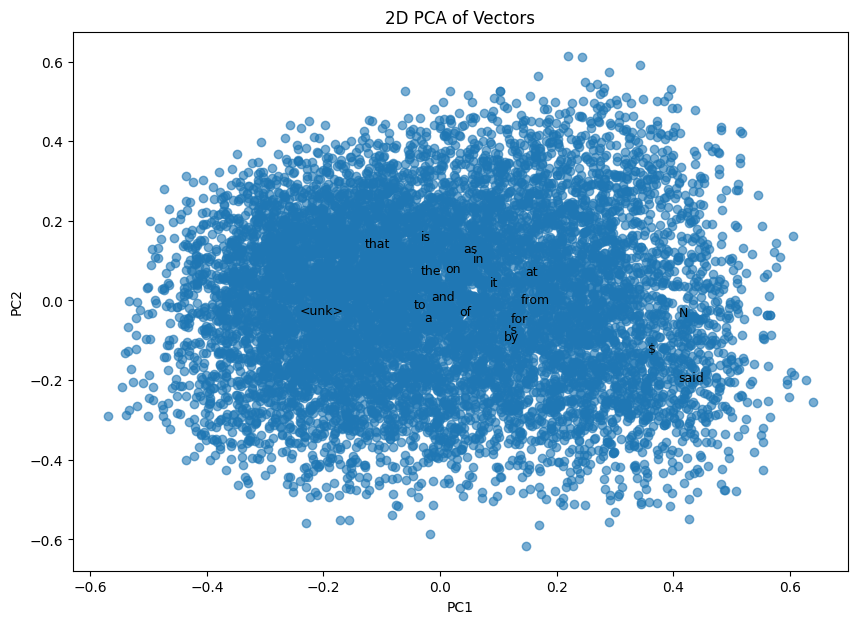

,the,<unk>,N,of,to,a,in,and,'s,that
the,1.000000,0.879949,0.500451,0.928271,0.876799,0.867887,0.890324,0.849439,0.589395,0.717517
<unk>,0.879949,1.000000,0.330127,0.895466,0.811242,0.835101,0.793586,0.891254,0.540290,0.587860
N,0.500451,0.330127,1.000000,0.538909,0.598742,0.506013,0.532502,0.392628,0.246037,0.187996
of,0.928271,0.895466,0.538909,1.000000,0.818759,0.858583,0.844362,0.854669,0.550450,0.634885
to,0.876799,0.811242,0.598742,0.818759,1.000000,0.787873,0.762181,0.799445,0.482313,0.663150
a,0.867887,0.835101,0.506013,0.858583,0.787873,1.000000,0.788372,0.720347,0.524820,0.612941
in,0.890324,0.793586,0.532502,0.844362,0.762181,0.788372,1.000000,0.786476,0.421864,0.621072
and,0.849439,0.891254,0.392628,0.854669,0.799445,0.720347,0.786476,1.000000,0.442051,0.464073
's,0.589395,0.540290,0.246037,0.550450,0.482313,0.524820,0.421864,0.442051,1.000000,0.336989
that,0.717517,0.587860,0.187996,0.634885,0.663150,0.612941,0.621072,0.464073,0.336989,1.000000


In [83]:
# Plotting vectors in 2D and viewing cosine similarity between first 10 words

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(vector_df.values)

plt.figure(figsize=(10, 7))
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6)
for i, word in enumerate(vector_df.index[:20]):  # Label first 20 points
    plt.text(reduced[i, 0], reduced[i, 1], word, fontsize=9)
plt.title('2D PCA of Vectors')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Compute cosine similarity for the first 10 vectors
sim_matrix = cosine_similarity(vector_df.iloc[:10])
sim_df = pd.DataFrame(sim_matrix, index=vector_df.index[:10], columns=vector_df.index[:10])
sim_df

Cluster counts:
  Cluster 0: 4411
  Cluster 1: 5589

Top 15 words closest to centroid of Cluster 0:
of, the, and, in, to, limited, a, held, <unk>, technology, potential, western, operation, data, control

Top 15 words closest to centroid of Cluster 1:
<unk>, free, political, the, black, way, press, private, having, party, making, washington, using, crime, out


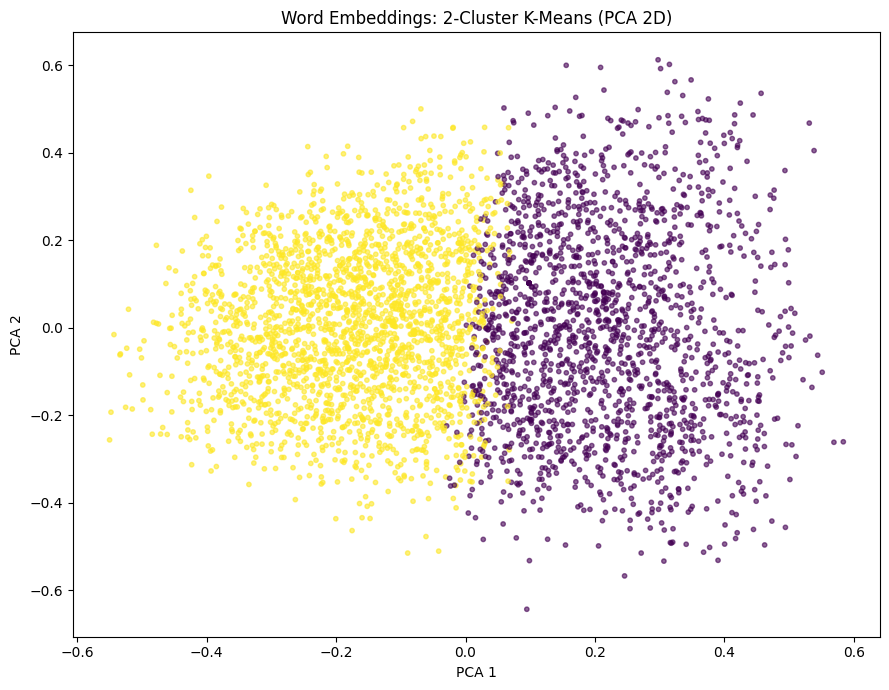

In [84]:
# === K-Means clustering into 2 groups + 2D visualization ===

def cluster_two(df: pd.DataFrame, sample_for_plot: int = 4000, show_examples: int = 15, random_state: int = 42):
    assert isinstance(df, pd.DataFrame) and df.shape[0] > 2, "vector_df must be a non-empty DataFrame with word vectors."

    # 1) Fit K-Means (on full vectors)
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=random_state)
    labels = kmeans.fit_predict(df.values)

    # Attach cluster labels to a copy so we don't mutate your original reference unexpectedly
    df_with_labels = df.copy()
    df_with_labels["cluster2"] = labels

    # 2) Quick summary
    counts = df_with_labels["cluster2"].value_counts().sort_index()
    print("Cluster counts:")
    for c, n in counts.items():
        print(f"  Cluster {c}: {n}")

    # 3) Show representative words per cluster (closest to centroid by cosine similarity)
    centroids = kmeans.cluster_centers_
    sims = cosine_similarity(centroids, df.values)  # shape (2, vocab_size)

    for c in [0, 1]:
        top_idx = np.argsort(-sims[c])[:show_examples]
        top_words = df.index[top_idx].tolist()
        print(f"\nTop {show_examples} words closest to centroid of Cluster {c}:")
        print(", ".join(top_words))

    # 4) 2D PCA for visualization (sample if huge for speed)
    if len(df) > sample_for_plot:
        rng = np.random.default_rng(random_state)
        sample_idx = rng.choice(len(df), size=sample_for_plot, replace=False)
    else:
        sample_idx = np.arange(len(df))

    df_sample = df_with_labels.iloc[sample_idx]
    pca = PCA(n_components=2, random_state=random_state)
    reduced = pca.fit_transform(df_sample.drop(columns=["cluster2"]).values)

    # 5) Scatter plot colored by cluster
    plt.figure(figsize=(9, 7))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=df_sample["cluster2"].values, alpha=0.6, s=10)
    plt.title("Word Embeddings: 2-Cluster K-Means (PCA 2D)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.tight_layout()
    plt.show()

    return df_with_labels, kmeans, pca

# Run it:

try:
    _ = vector_df  # does the variable exist?
except NameError:
    # Recreate it if the kernel was restarted or cells ran out of order
    vector_df = load_vectors("sample_vectors.txt")

# (Optional but helpful) ensure all entries are numeric and drop any bad rows
vector_df = vector_df.apply(pd.to_numeric, errors="coerce").dropna()

# Now run clustering
vector_df_labeled, kmeans2, pca2 = cluster_two(vector_df)



In [85]:
# === K-Means clustering into N groups + 2D visualization ===


def cluster_words(df: pd.DataFrame, n_clusters: int = 4, sample_for_plot: int = 4000,
                  show_examples: int = 15, random_state: int = 42):
    assert isinstance(df, pd.DataFrame) and df.shape[0] > n_clusters, "vector_df must be a valid DataFrame."

    # 1) Fit K-Means
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)
    labels = kmeans.fit_predict(df.values)

    # Attach labels
    df_with_labels = df.copy()
    df_with_labels[f"cluster{n_clusters}"] = labels

    # 2) Quick summary
    counts = df_with_labels[f"cluster{n_clusters}"].value_counts().sort_index()
    print("Cluster counts:")
    for c, n in counts.items():
        print(f"  Cluster {c}: {n}")

    # 3) Show representative words
    centroids = kmeans.cluster_centers_
    sims = cosine_similarity(centroids, df.values)  # shape (n_clusters, vocab_size)

    for c in range(n_clusters):
        top_idx = np.argsort(-sims[c])[:show_examples]
        top_words = df.index[top_idx].tolist()
        print(f"\nTop {show_examples} words closest to centroid of Cluster {c}:")
        print(", ".join(top_words))

    # 4) 2D PCA visualization
    if len(df) > sample_for_plot:
        rng = np.random.default_rng(random_state)
        sample_idx = rng.choice(len(df), size=sample_for_plot, replace=False)
    else:
        sample_idx = np.arange(len(df))

    df_sample = df_with_labels.iloc[sample_idx]
    pca = PCA(n_components=2, random_state=random_state)
    reduced = pca.fit_transform(df_sample.drop(columns=[f"cluster{n_clusters}"]).values)

    plt.figure(figsize=(9, 7))
    plt.scatter(reduced[:, 0], reduced[:, 1],
                c=df_sample[f"cluster{n_clusters}"].values, alpha=0.6, s=10, cmap="tab10")
    plt.title(f"Word Embeddings: {n_clusters}-Cluster K-Means (PCA 2D)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.tight_layout()
    plt.show()

    return df_with_labels, kmeans, pca


Cluster counts:
  Cluster 0: 2320
  Cluster 1: 3128
  Cluster 2: 2263
  Cluster 3: 2289

Top 15 words closest to centroid of Cluster 0:
press, private, policy, washington, political, congressional, proposals, defense, opposition, free, act, the, security, justice, action

Top 15 words closest to centroid of Cluster 1:
<unk>, out, black, play, red, work, room, whose, game, way, english, sort, heart, fire, once

Top 15 words closest to centroid of Cluster 2:
closely, control, chemical, communications, subsidiary, partners, of, specialty, energy, management, resources, ltd., southern, broadcasting, acquisition

Top 15 words closest to centroid of Cluster 3:
the, relatively, despite, especially, in, generally, sharply, mostly, ahead, modest, high, largely, large, while, rising


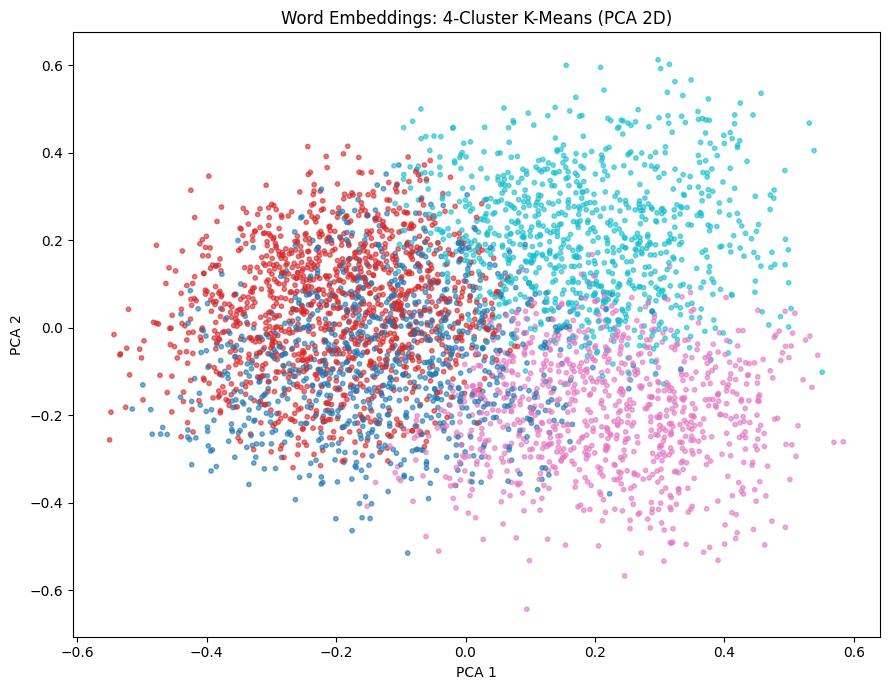

In [86]:
vector_df_labeled, kmeans4, pca4 = cluster_words(vector_df, n_clusters=4)


#Analyzing distances between clusters
Now we move into creating clusters and attempting to use the offsets between cluster centers to identify the meaning that offset expresses in the vector space

In [87]:
# define cosine_similarity function for later use
from numpy.linalg import norm

def cosine_similarity(a, b):
  if norm(a) == 0 or norm(b) == 0:
    return 0
  return np.dot(a, b) / (norm(a) * norm(b))

In [88]:
# helper functions and clustering functions using the KMeans library
from sklearn.cluster import KMeans

def kmeans_clusters(n_clusters): # create and return clusters
  kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
  labels = kmeans.fit_predict(X)

  clusters = [[] for x in range(n_clusters)]
  for word, label in zip(words, labels):
    clusters[label].append(word)

  return clusters

def kmeans_center(n_clusters): # returns average vector from each cluster
  kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
  labels = kmeans.fit_predict(X)
  return kmeans.cluster_centers_

def kmeans_similarity_matrix(n_clusters): # returns square matrix with vectors length n_clusters and cosine similarity between the center of clusters [i,j]
  similarity_matrix = np.zeros((n_clusters, n_clusters))
  centroids = kmeans_center(n_clusters)

  for i in range(n_clusters):
    for j in range(n_clusters):
      similarity_matrix[i,j] = cosine_similarity(centroids[i], centroids[j])

  return similarity_matrix


In [89]:
# find closest_x_words based on user input via cosine similarities
import random

def closest_x_words(vector, word_to_vector, x):
  similarities = []
  # check similarities of all words to given vector
  for word, vec in word_to_vector.items():
    sim = cosine_similarity(vector, vec)
    similarities.append((word, sim))

  # sorting by highest similarity
  similarities.sort(key=lambda x: x[1], reverse=True)
  return similarities[:x] # return first x


In [90]:
# this function splits the vector space into n_clusters number of clusters
#    it then gathers sample_size number of sample words from each cluster
#    then it finds the distance between all clusters' centers and stores them
#    then it takes each sample word and applies the offset between it's home category
#       and another and finds the nearest words to this new vector
#    the function then returns a really messy and overcomplicated array that stores all that information
def create_and_sample_clusters(n_clusters, sample_size):
  # create clusters and sample from each
  clusters = kmeans_clusters(n_clusters)
  rand_samples = []
  for i in range(n_clusters):
    sample_line = []
    for j in range(n_clusters):
      sample_line.append(random.sample(clusters[i], sample_size))
    rand_samples.append(sample_line)

  # get cluster centers and distances between cluster centers
  cluster_centers = kmeans_center(n_clusters)
  cluster_dists = []
  for i in range(n_clusters):
    cd_row = []
    for j in range(n_clusters):
      cd_row.append(cluster_centers[j] - cluster_centers[i])
    cluster_dists.append(cd_row)

  results = []

  # 3 samples per cluster
  # x clusters
  # x^2 total results, each with 3 closest words each

  # cluster dists is a 2d array with the distance from i to j in upper triangle
  # then distance from j to i is in lower triangle
  for i in range(n_clusters):
    result_line = []
    for j in range(n_clusters):
      for sample in rand_samples[i][j]:
        if i == j:
          tmp = (sample, f"from {i} to {j}", closest_x_words(embeddings[sample], embeddings, sample_size))
          result_line.append(tmp)
        else:
          result_line.append((sample, f"from {i} to {j}", closest_x_words(embeddings[sample] + cluster_dists[i][j], embeddings, sample_size)))
    results.append(result_line)

  return results

# prints the output of the previous function in a more readable manner
def print_nice(input):
  # output is an array n_clusters by n_clusters
  # each element of the 2d array has a list of 3 words and the 3 closest words to it after transformation
  # each element is composed of an ordered triple, of which element at index 2 is a list of 3 ordered pairs
  print("cluster direction   sample word    closest neighbors")
  for i in range(len(input)):
    for j in range(len(input)): # this is not right yet
      print(f"from {i} to {j} === {input[i][j*3][0]:>15}    neighbors: {input[i][j*3][2][0][0]}, {input[i][j*3][2][1][0]}, {input[i][j*3][2][2][0]}")
      print(f"                {input[i][1+j*3][0]:>15}    neighbors: {input[i][1+j*3][2][0][0]}, {input[i][1+j*3][2][1][0]}, {input[i][1+j*3][2][2][0]}")
      print(f"                {input[i][2+j*3][0]:>15}    neighbors: {input[i][2+j*3][2][0][0]}, {input[i][2+j*3][2][1][0]}, {input[i][2+j*3][2][2][0]}")
      print()



The next 3 cells cluster the words into 2, 4, and 8 groups then illustrate information in attempts to help the user discover the relationship between groups.


* Each cluster is numbered from 0 to n_clusters - 1.
* Three sample words are taken from each cluster.
* The offset between groups i and j is computed.
* This offset is added to each sample word in.
* Then, the 3 nearest neighbors to this new vector are displayed



In [91]:
# Try analysis with 2 clusters
n_clusters = 2
sample_size = 3

print_nice(create_and_sample_clusters(n_clusters, sample_size))

cluster direction   sample word    closest neighbors
from 0 to 0 ===         stevens    neighbors: stevens, gatward, hahn
                    recognition    neighbors: recognition, deal, pilot
                     world-wide    neighbors: world-wide, production, manufacturing

from 0 to 1 ===          noting    neighbors: noting, recalled, finally
                        yielded    neighbors: yielded, factory, hours
                 capitalization    neighbors: capitalization, fund, junk-bond

from 1 to 0 ===             've    neighbors: 've, 're, 'll
                        experts    neighbors: experts, however, although
                       deficits    neighbors: deficits, gap, currencies

from 1 to 1 ===           suits    neighbors: suits, opposing, groups
                    installment    neighbors: installment, assault, base
                         detect    neighbors: detect, gene, found



In [92]:
# Repeat for 4 clusters
n_clusters = 4
sample_size = 3

print_nice(create_and_sample_clusters(n_clusters, sample_size))

cluster direction   sample word    closest neighbors
from 0 to 0 ===         verdict    neighbors: verdict, patent, illinois
                    exclusively    neighbors: exclusively, arrangements, breakfast
                       township    neighbors: township, violations, including

from 0 to 1 ===        changing    neighbors: changing, whose, where
                    independent    neighbors: independent, offers, outside
                      permitted    neighbors: permitted, different, somewhere

from 0 to 2 ===      cease-fire    neighbors: cease-fire, torrijos, noriega
                         issued    neighbors: issued, offering, australian
                        leipzig    neighbors: leipzig, eurocom, femina

from 0 to 3 ===         willful    neighbors: willful, instance, permit
                  beneficiaries    neighbors: beneficiaries, catastrophic, hedge
                        damages    neighbors: damages, claims, resulting

from 1 to 0 ===           asked    neigh

In [93]:
# Repeat for 8 clusters

n_clusters = 8
sample_size = 3

print_nice(create_and_sample_clusters(n_clusters, sample_size))

cluster direction   sample word    closest neighbors
from 0 to 0 ===             fcc    neighbors: fcc, valid, existence
                          minn.    neighbors: minn., ariz., subcommittee
                      conflicts    neighbors: conflicts, representation, both

from 0 to 1 ===          clause    neighbors: clause, can, answer
                            dam    neighbors: dam, gorky, hardly
                       backlash    neighbors: backlash, handful, dunes

from 0 to 2 ===           legal    neighbors: legal, meanwhile, aggressive
                      mackenzie    neighbors: mackenzie, delta, foothills
                         unesco    neighbors: unesco, nervousness, trim

from 0 to 3 ===        monetary    neighbors: monetary, lawson, greenspan
                          fresh    neighbors: fresh, light, again
                            s&l    neighbors: s&l, masson, seidman

from 0 to 4 ===         calling    neighbors: calling, maintenance, applied
                  

# The Onset of Reality:
At this point we started to question what was going on. We knew our models weren't performing as expected since the new vectors we created were closest to the sample word they started with, meaning our offsets between group centers were very small. So we tried larger numbers of clusters, which didn't help. Then we discovered some ways to evaluate clustering models and implemented them to see what was going on.

In [94]:
# remove any zero vectors that may cause issues

nonzero_mask = np.linalg.norm(X, axis=1) > 0
X = X[nonzero_mask]

In [95]:
# testing KMeans clusters with silhouette score and davies bouldine score
from sklearn.metrics import silhouette_score, davies_bouldin_score
from collections import defaultdict

n_clusters = 2

while n_clusters < 512:
  print(f"testing with {n_clusters} clusters")
  # run kmeans
  kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
  labels = kmeans.fit_predict(X)

  # group words by cluster
  clusters = defaultdict(list)
  for w, lbl in zip(words, labels):
    clusters[lbl].append(w)

  # silhouette score
  # <0.25     -> likely no clear structure
  # 0.25-0.50 -> weak structure
  # 0.50-0.70 -> reasonable structure
  # 0.70-1.00 -> strong/clear structure
  if len(set(labels)) > 1:  # need at least 2 clusters
    sil = silhouette_score(X, labels, metric="cosine")
    print("Silhouette score    :", round(sil, 4))
  else:
    print("Not enough clusters for silhouette score")

  # davies-bouldin
  # lower scores imply high compactness and well-separated clusters
  # <0.5    -> very good
  # 0.5-1.0 -> good
  # 1.0-2.0 -> weak
  # >2.0    -> poor
  if len(set(labels)) > 1:
    db = davies_bouldin_score(X, labels)
    print("Davies–Bouldin Index:", round(db, 4))
  else:
    print("Not enough clusters for Davies–Bouldin")
  print()
  n_clusters *= 2


testing with 2 clusters
Silhouette score    : 0.0976
Davies–Bouldin Index: 4.4126

testing with 4 clusters
Silhouette score    : 0.0805
Davies–Bouldin Index: 3.8945

testing with 8 clusters
Silhouette score    : 0.0833
Davies–Bouldin Index: 3.531

testing with 16 clusters
Silhouette score    : 0.0924
Davies–Bouldin Index: 3.2028

testing with 32 clusters
Silhouette score    : 0.0927
Davies–Bouldin Index: 3.0167

testing with 64 clusters
Silhouette score    : 0.0798
Davies–Bouldin Index: 2.9506

testing with 128 clusters
Silhouette score    : 0.0717
Davies–Bouldin Index: 2.9635

testing with 256 clusters
Silhouette score    : 0.0604
Davies–Bouldin Index: 2.8739



In [96]:
# AgglomerativeClustering with wilhouette and davies-bouldin
from sklearn.cluster import AgglomerativeClustering

n_clusters = 2

while n_clusters < 512:
  print(f"testing with {n_clusters} clusters")

  # run agglomerative clustering
  agg = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
  labels = agg.fit_predict(X)

  # group words by cluster
  clusters = defaultdict(list)
  for w, lbl in zip(words, labels):
    clusters[lbl].append(w)

  # silhouette score
  if len(set(labels)) > 1:  # need at least 2 clusters
    sil = silhouette_score(X, labels, metric="cosine")
    print("Silhouette score.   :", round(sil, 4))
  else:
    print("Not enough clusters for silhouette score")

  # davies-bouldin score
  if len(set(labels)) > 1:
    db = davies_bouldin_score(X, labels)
    print("Davies–Bouldin Index:", round(db, 4))
  else:
    print("Not enough clusters for Davies–Bouldin")

  print()
  n_clusters *= 2

testing with 2 clusters
Silhouette score.   : 0.1801
Davies–Bouldin Index: 0.8195

testing with 4 clusters
Silhouette score.   : 0.0707
Davies–Bouldin Index: 1.9723

testing with 8 clusters
Silhouette score.   : 0.0343
Davies–Bouldin Index: 2.9886

testing with 16 clusters
Silhouette score.   : 0.0091
Davies–Bouldin Index: 2.9609

testing with 32 clusters
Silhouette score.   : -0.0157
Davies–Bouldin Index: 3.0174

testing with 64 clusters
Silhouette score.   : -0.0074
Davies–Bouldin Index: 2.9957

testing with 128 clusters
Silhouette score.   : -0.0178
Davies–Bouldin Index: 2.7596

testing with 256 clusters
Silhouette score.   : -0.003
Davies–Bouldin Index: 2.5417



In [97]:
# HDBSCAN testing with silhouette and davies-bouldin
import hdbscan

# run hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=10, metric='euclidean')
clusterer.fit(X)
labels = clusterer.labels_

# group words by cluster
clusters = defaultdict(list)
for w, lbl in zip(words, labels):
  clusters[lbl].append(w)


# show results of silhouette score
mask = labels != -1
if mask.sum() > 1 and len(set(labels[mask])) > 1:
  sil = silhouette_score(X[mask], labels[mask], metric="cosine")
  print("Silhouette score:    ", round(sil, 4))
else:
  print("Not enough clusters for silhouette score")

# show results of davies-bouldin test
if mask.sum() > 1 and len(set(labels[mask])) > 1:
  db = davies_bouldin_score(X[mask], labels[mask])
  print("Davies–Bouldin Index:", round(db, 4))
else:
  print("Not enough clusters for Davies–Bouldin")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Silhouette score:     0.3619
Davies–Bouldin Index: 1.6851


So with only 1 exception for each test, we found that
* All models are likely to have little to no structure via the sillhouette test
and
* All models show poor compactness and separation via their Davies-Bouldin Index

# **Key Takeaways:**

We learned that clustering models do not work well on this set of vector embeddings. After reexamining the visualizations from the start, this conclusion makes sense regarding the clustering graph given with 4 clusters, but not so much when given 2.

Since our goal was to extract meaning out of the offsets of distinct groups, the absence of distinct groups caused a failure to obtain these meanings.